# CBIR CON HISTOGRAMA DE COLOR

In [1]:
import cv2
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import random
import os

## Almacenamos los paths de todas las imagenes


In [2]:
n_imgs = 100
carpetas = ["autobus-n04487081", "clavos-n03804744", "coche-n02814533", "collarin-n03814639", "desatascador-n03970156",
         "gatos-n02123394", "mono-n02480495", "puentes-n04532670", "silla-n04099969", "perro-n02099601", 
            "pato-n01855672", "pizza-n07873807", "mar-n09428293", "ipod-n03584254", "platano-n07753592", "mascara_gas-n03424325", 
            "pajarita-n02883205", "mosca-n02190166", "helado-n07615774", "canon-n02950826"]
len(carpetas)

20

In [3]:
def get_images_path(carpetas, n_imgs):
    images_path = {}
    for carpeta in carpetas:
        for i in range(n_imgs):
            images_path[(carpeta[-7:], str(i))] = f'../dataset/{carpeta}/{carpeta[-9:]}_{str(i)}.JPEG'
    return images_path #Devuelve un diccionario en el que la clave es (carpeta, id), y los valores los paths

In [4]:
images_path = get_images_path(carpetas, n_imgs)
len(images_path)

2000

## Vemos como obtenemos el histograma de color en una imagen

In [5]:
# Función para calcular el histograma de color de una imagen
def calculate_color_histogram(image, bins=8):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    histograms = []
    for i in range(3):
        hist = cv2.calcHist([rgb_image], [i], None, [bins], [0, 256])
        histograms.append(hist)
    histogram = np.concatenate(histograms)
    histogram = cv2.normalize(histogram, None).flatten()
    return histogram

In [6]:
histograma_1 = calculate_color_histogram(cv2.imread(list(images_path.values())[0]))
histograma_1

array([0.25785977, 0.17695625, 0.23046215, 0.33973023, 0.20403153,
       0.06736586, 0.0235297 , 0.02030645, 0.11120202, 0.17824556,
       0.31491122, 0.3706734 , 0.20983337, 0.08670534, 0.02385203,
       0.024819  , 0.10120995, 0.17308836, 0.29363778, 0.4151542 ,
       0.21853614, 0.07381235, 0.02965387, 0.01514926], dtype=float32)

In [7]:
len(histograma_1)

24

Vemos que por cada imagen se genera un vector con 24 valores

## Obtenemos los histogramas de color de todas nuestras imagenes

In [8]:
if os.path.exists('./npy_mat/color_histograms.npy'):
    color_histograms = np.load('./npy_mat/color_histograms.npy')
else:
    color_histograms = np.empty((0,26))
    for idx in images_path:
        im = cv2.imread(images_path[idx])
        histogram = calculate_color_histogram(im)
        histograms_arr = np.array(histogram)  
        histograms_arr = np.insert(histograms_arr, 0, idx[1])
        histograms_arr = np.insert(histograms_arr, 0, idx[0])
        color_histograms =  np.vstack([color_histograms, histograms_arr]) #Pos 0 -> carpeta, Pos 1 -> numero de imagen
    np.save('color_histograms', color_histograms)
color_histograms.shape

(2000, 26)

## Entrenamos knn

In [9]:
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=5, algorithm='auto', metric='euclidean')

color_histograms_train = color_histograms[:, 2:] #Quitamos los dos primeros pertenecientes a indices de la imagen
knn.fit(color_histograms_train)

NearestNeighbors(metric='euclidean')

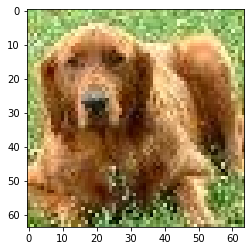

In [13]:
new_image_path = '../dataset/test/n02099601_130.jpeg'
new_img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

## Obtenemos las imagenes más similares a una nueva imagen

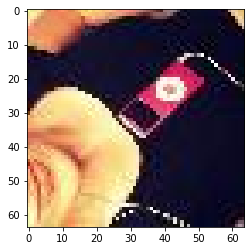

In [16]:
new_image_path = list(images_path.values())[random.randrange(0, len(carpetas)*n_imgs - 1)] 
new_img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

# Calcular el histograma de la nueva imagen
new_histogram = calculate_color_histogram(new_img)
histogram_flat = new_histogram.reshape(1, -1)
distance, indice = knn.kneighbors(histogram_flat, n_neighbors=5)


idx_dist = list(zip(indice[0], distance[0]))
idx_dist = [tupla[0] for tupla in sorted(idx_dist, key=lambda x: x[1])]
ids = []
for idx in idx_dist:
        carpeta = str(int(color_histograms[idx,0]))
        num_img = str(int(color_histograms[idx,1]))
        ids.append((carpeta, num_img))

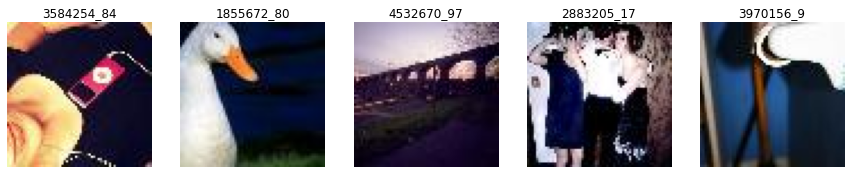

In [17]:
def display_n_similar(sorted_indexes, n):
    if n <= 0:
        print("El valor de n debe ser mayor que 0.")
        return

    if n > len(sorted_indexes):
        print(f"Solo hay {len(sorted_indexes)} imágenes en la lista. Mostrando todas.")
        n = len(sorted_indexes)
    fig, axs = plt.subplots(1, n, figsize=(15,15))
    for i in range(n):
        n_carpeta = (sorted_indexes[i][0])
        n_img = (sorted_indexes[i][1])
        path = images_path[(n_carpeta, n_img)]
        im = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        axs[i].imshow(im)
        axs[i].axis('off')
        titulo = f'{n_carpeta}_{n_img}'
        axs[i].set_title(titulo)
        
    plt.show()
display_n_similar(ids, 5)